In [2]:
import pandas as pd
import tensorflow as tf
import seaborn as sns

In [3]:
df = pd.read_csv('BTC_USD_2014-11-03_2022-02-04-CoinDesk.csv')

In [4]:
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2014-11-03,324.467934,323.826186,333.539527,323.106623
1,BTC,2014-11-04,328.644408,324.424164,330.671610,320.902900
2,BTC,2014-11-05,337.921358,328.653046,342.384170,328.597125
3,BTC,2014-11-06,348.992860,337.921358,352.585895,336.236830
4,BTC,2014-11-07,341.459753,348.992860,351.651854,340.196145


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2651 entries, 0 to 2650
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2651 non-null   object 
 1   Date                 2651 non-null   object 
 2   Closing Price (USD)  2651 non-null   float64
 3   24h Open (USD)       2651 non-null   float64
 4   24h High (USD)       2651 non-null   float64
 5   24h Low (USD)        2651 non-null   float64
dtypes: float64(4), object(2)
memory usage: 124.4+ KB


Text(0.5, 1.0, 'Closing Price of Bitcoin from 2013 to 2022')

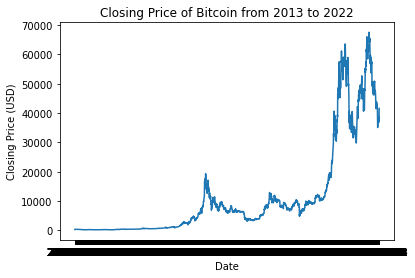

In [6]:
sns.lineplot(data=df, x='Date', y='Closing Price (USD)').set_title('Closing Price of Bitcoin from 2013 to 2022')

In [7]:
import csv
from datetime import datetime

In [8]:
timesteps = []
btc_price = []
with open('BTC_USD_2014-11-03_2022-02-04-CoinDesk.csv') as f:
    csv_reader = csv.reader(f, delimiter= ',')
    next(csv_reader)
    for line in csv_reader:
        timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
        btc_price.append(float(line[2])) # Closing price


In [9]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 0, 'Date')

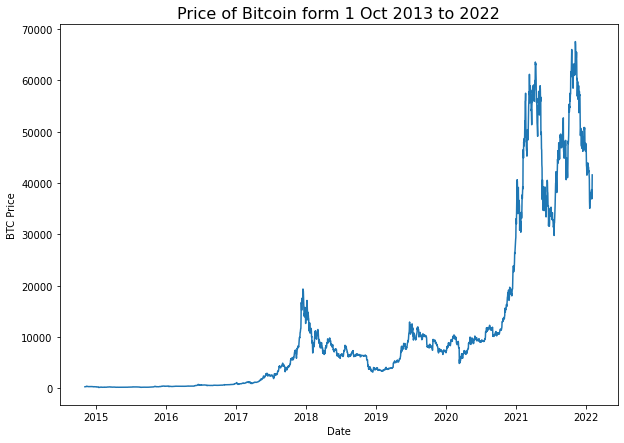

In [10]:
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin form 1 Oct 2013 to 2022", fontsize=16)
plt.xlabel("Date")

In [11]:
## Create train and test sets of our time series data
from sklearn.model_selection import train_test_split

## Don't do naive train_test split!!! Temporal coherence will be affected.
split_size = int(0.8 * len(df))

In [12]:
X_train, y_train = timesteps[:split_size], btc_price[:split_size]
X_test, y_test = timesteps[split_size:], btc_price[split_size:]

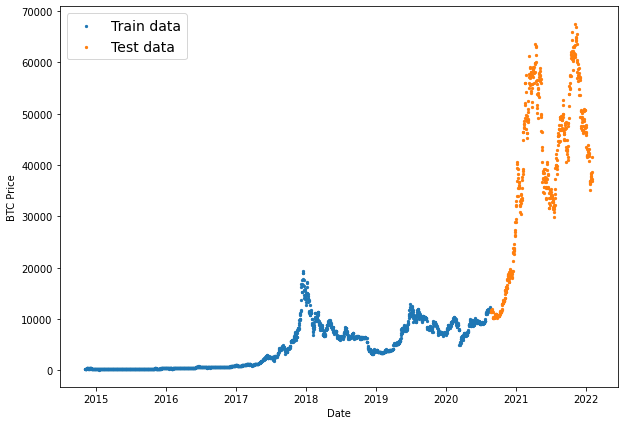

In [13]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label = "Train data")
plt.scatter(X_test, y_test, s =5, label = "Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show()

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

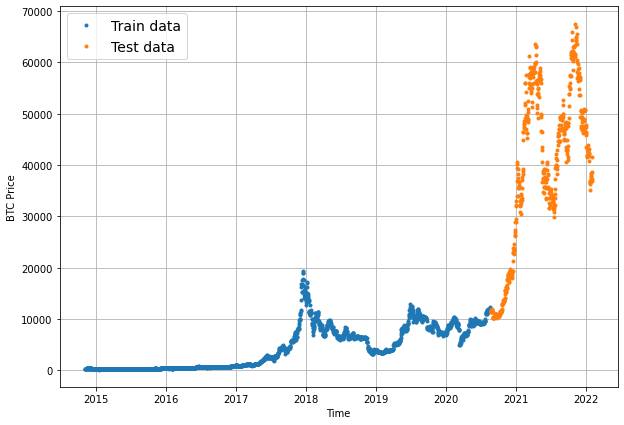

In [15]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

In [16]:
naive_forecast = np.array(y_test[:-1])

In [17]:
def MASE(y_true, y_pred):
    '''
    Mean Absolute Scaled Error implementation for use in tensorflow.

    Assumes no seasonality.
    '''

    mae = tf.reduce_mean(tf.abs(y_true - y_pred))

    # mae naive forecase no seasonality
    mae_naive_ns = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

    return mae / mae_naive_ns


In [18]:
MASE(y_true=np.array(y_test[1:]), y_pred=naive_forecast).numpy()

0.998293997073448

In [117]:
def evaluate_preds(y_true, y_pred) -> dict:
    '''


    @warning Converts all datatypes to float32 when evaluating

    '''
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
    mase = MASE(y_true, y_pred)

    if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)
        mase = tf.reduce_mean(mase)

    return {
        "MAE" : mae.numpy(),
        "MSE" : mse.numpy(),
        "RSME" : rmse.numpy(),
        "MAPE" : mape.numpy(),
        "MASE" : mase.numpy(),
    }

In [122]:
naive_res = evaluate_preds(y_true=y_test[1:], y_pred = naive_forecast)

### Windowing our datasets - turning ts data into supervised learning

In [21]:
HORIZON = 1
WINDOW_SIZE = 7

In [22]:
def get_labelled_window(x, horizon = HORIZON):
    '''
    Creates labels for windowed dataset

    Input : [0,1,2,3,4,5,6,7]
    '''
    return x[:, :-horizon], x[:, -horizon:]

In [23]:
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8) + 1, axis = 0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]])>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[8]])>)

In [24]:
def make_windows(x, window_size = WINDOW_SIZE, horizon = HORIZON):
    '''
    Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
    '''
    # Create a nested window
    window_step = np.expand_dims(np.arange(window_size+ horizon), axis= 0)

    window_index = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon - 1)), axis=0).T

    # Index on the target array
    windowed_array = x[window_index]

    # windows with labels
    windows, labels = get_labelled_window(windowed_array, horizon=horizon)
    return windows, labels


In [25]:
np.expand_dims(np.arange(8), axis = 0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [51]:
windows, labels = make_windows(np.array(btc_price))
windows.shape, labels.shape

((2644, 7), (2644, 1))

In [27]:
btc_price[0]

324.467934

In [28]:
windows[0]

array([324.467934, 328.644408, 337.921358, 348.99286 , 341.459753,
       344.745289, 357.239982])

In [29]:
for i in range(3):
    print(f"Window : {windows[i]} -> Label : {labels[i]}")

Window : [324.467934 328.644408 337.921358 348.99286  341.459753 344.745289
 357.239982] -> Label : [371.116917]
Window : [328.644408 337.921358 348.99286  341.459753 344.745289 357.239982
 371.116917] -> Label : [366.664633]
Window : [337.921358 348.99286  341.459753 344.745289 357.239982 371.116917
 366.664633] -> Label : [428.882925]


In [52]:
def train_test_split_windows(windows, labels, test_split= 0.2):
    '''
    Splits matching pairs of windows and labels into train and test splits
    '''

    split_size = int(len(windows) * (1 - test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows, train_labels, test_windows, test_labels

In [53]:
train_windows, train_labels, test_windows, test_labels = train_test_split_windows(windows, labels)

### Make a modelling checkpoint

In [54]:
import os

# Model checkpoint callback with a specific filename

def checkpoint_cb( model_name, save_path = 'models'):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), verbose=0, save_best_only=True)


In [55]:
### Basic Linear Regression model
from tensorflow.keras import layers
tf.random.set_seed(42)

model1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear') # no activatoin
], name = 'Basic_Regression')

model1.compile(loss = "mae", optimizer = tf.keras.optimizers.Adam(), metrics=["mae", "mse"])

model1.fit(
    x = train_windows, 
    y = train_labels, 
    epochs=100, 
    verbose = 1,
    batch_size=128, 
    validation_data = (test_windows, test_labels), 
    callbacks=  [checkpoint_cb(model_name=model1.name)])

Epoch 1/100
17/17 [==============================] - 1s 23ms/step - loss: 1100.0088 - mae: 1100.0088 - mse: 3562633.0000 - val_loss: 4832.4214 - val_mae: 4832.4214 - val_mse: 35321380.0000
Epoch 2/100
17/17 [==============================] - 0s 21ms/step - loss: 326.0253 - mae: 326.0253 - mse: 339046.6562 - val_loss: 1938.8119 - val_mae: 1938.8119 - val_mse: 7271532.5000
Epoch 3/100
17/17 [==============================] - 0s 19ms/step - loss: 238.5033 - mae: 238.5033 - mse: 216512.0469 - val_loss: 1862.6833 - val_mae: 1862.6833 - val_mse: 6723281.0000
Epoch 4/100
17/17 [==============================] - 0s 19ms/step - loss: 217.9016 - mae: 217.9016 - mse: 189999.0000 - val_loss: 1797.5853 - val_mae: 1797.5853 - val_mse: 6169264.5000
Epoch 5/100
17/17 [==============================] - 0s 19ms/step - loss: 209.6864 - mae: 209.6864 - mse: 181247.8594 - val_loss: 1759.8129 - val_mae: 1759.8129 - val_mse: 5802266.0000
Epoch 6/100
17/17 [==============================] - 1s 36ms/step - los

In [56]:
model1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 625us/step - loss: 1272.8014 - mae: 1272.8014 - mse: 3129840.5000


[1272.8013916015625, 1272.8013916015625, 3129840.5]

In [57]:
model1 = tf.keras.models.load_model('models/Basic_Regression')

In [58]:
model1.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 625us/step - loss: 1146.1456 - mae: 1146.1456 - mse: 2788494.7500


[1146.1456298828125, 1146.1456298828125, 2788494.75]

In [59]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

In [60]:
model_preds = make_preds(model1, test_windows)

In [61]:
model_res = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred = model_preds)

In [64]:
model_res

{'MAE': 1146.1455,
 'MSE': 2788495.0,
 'RSME': 1669.8788,
 'MAPE': 2.8602996,
 'MASE': 1.0055571}

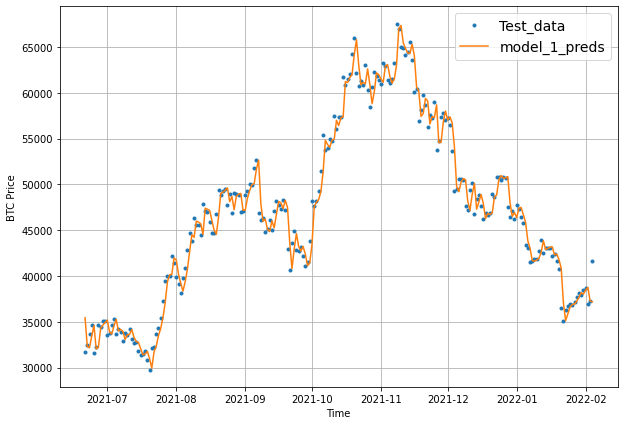

In [66]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_preds, start=offset, format="-", label="model_1_preds")

In [67]:
HORIZON = 1
WINDOW_SIZE = 30

windows, labels = make_windows(np.array(btc_price), horizon=HORIZON, window_size=WINDOW_SIZE)

In [68]:
windows.shape

(2621, 30)

In [69]:
labels.shape

(2621, 1)

In [70]:
train_windows, train_labels, test_windows, test_labels = train_test_split_windows(windows, labels)

In [71]:
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape, 

((2096, 30), (2096, 1), (525, 30), (525, 1))

In [73]:
tf.random.set_seed(42)

model2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON),
], name='Basic_Regression_One_month')

model2.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model2.fit(
    x=train_windows,
    y=train_labels,
    epochs= 100,
    batch_size = 128,
    verbose= 0,
    validation_data = (test_windows, test_labels),
    callbacks=[checkpoint_cb(model2.name)]
)

INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorflow:Assets written to: models\Basic_Regression_One_month\assets
INFO:tensorf

In [74]:
model2.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 562us/step - loss: 1254.8922


1254.8922119140625

In [76]:
model2=tf.keras.models.load_model('models/Basic_Regression_One_month')

In [77]:
model2.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 562us/step - loss: 1244.7632


1244.76318359375

In [78]:
model2_preds = make_preds(model2, test_windows)


In [79]:
model2_res = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model2_preds)

In [80]:
model_res

{'MAE': 1146.1455,
 'MSE': 2788495.0,
 'RSME': 1669.8788,
 'MAPE': 2.8602996,
 'MASE': 1.0055571}

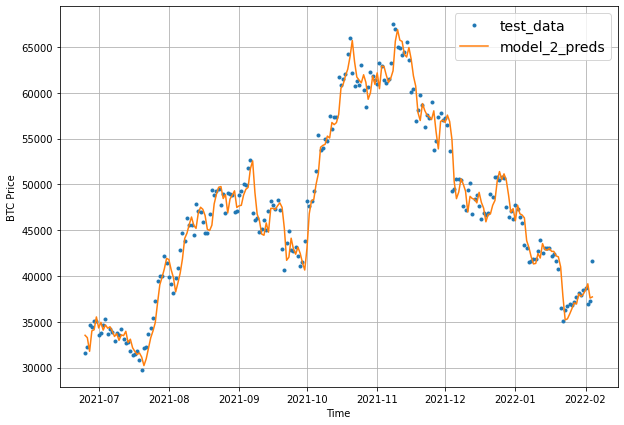

In [82]:

offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model2_preds, start=offset, format="-", label="model_2_preds")

In [106]:
HORIZON = 7
WINDOW_SIZE = 30

windows, labels = make_windows(np.array(btc_price), window_size=WINDOW_SIZE, horizon=HORIZON)
windows.shape, labels.shape

((2615, 30), (2615, 7))

In [107]:
train_windows, train_labels, test_windows, test_labels = train_test_split_windows(windows, labels)

In [108]:
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape

((2092, 30), (2092, 7), (523, 30), (523, 7))

In [109]:
tf.random.set_seed(42)

model3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON),
], name='Big_Horizon_Big_Window')

model3.compile(loss='mae', optimizer = tf.keras.optimizers.Adam())

In [110]:
model3.fit(
    x=train_windows,
    y=train_labels,
    epochs = 100,
    batch_size = 128,
    verbose=0,
    validation_data=(test_windows, test_labels),
    callbacks=[checkpoint_cb(model3.name)]
)

INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window\assets
INFO:tensorflow:Assets written to: models\Big_Horizon_Big_Window

In [111]:
model3.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 562us/step - loss: 2409.2229


2409.222900390625

In [112]:
model3= tf.keras.models.load_model('models/Big_Horizon_Big_Window')

In [113]:
model3.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 562us/step - loss: 2409.2229


2409.222900390625

In [114]:
model3_preds = make_preds(model3, test_windows)

In [118]:
model3_res = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model3_preds)

In [119]:
model3_res

{'MAE': 2409.223,
 'MSE': 11583614.0,
 'RSME': 2754.9846,
 'MAPE': 6.0454555,
 'MASE': 2.1096451}

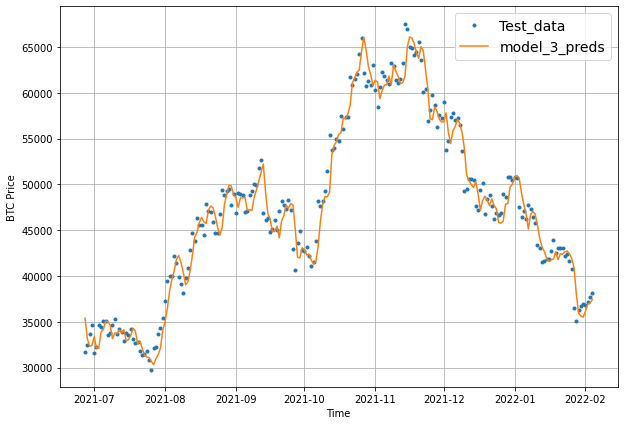

In [121]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

<AxesSubplot:>

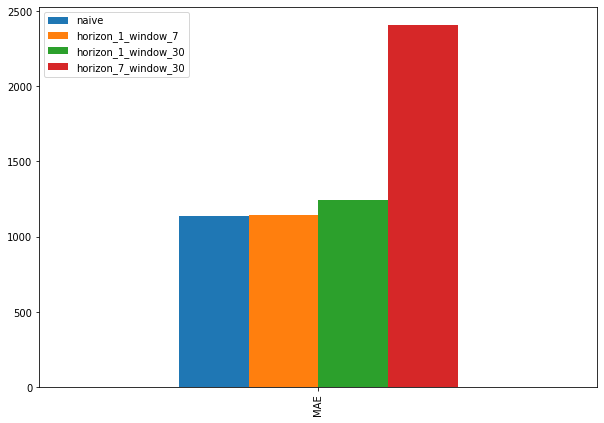

In [126]:
pd.DataFrame({
    "naive" : naive_res["MAE"],
    "horizon_1_window_7" : model_res["MAE"],
    "horizon_1_window_30" : model2_res["MAE"],
    "horizon_7_window_30" : model3_res["MAE"],
     
}, index=["MAE"]).plot(figsize=(10, 7), kind="bar")

### Conv 1D

In [127]:
HORIZON = 1
WINDOW_SIZE = 7

In [128]:
windows, labels = make_windows(np.array(btc_price), window_size=WINDOW_SIZE, horizon=HORIZON)

In [129]:
windows.shape, labels.shape

((2644, 7), (2644, 1))

In [130]:
train_windows, train_labels, test_windows, test_labels = train_test_split_windows(windows, labels)
train_windows.shape, train_labels.shape, test_windows.shape, test_labels.shape 


((2115, 7), (2115, 1), (529, 7), (529, 1))

In [131]:
### Reshape time series into "convolutional" layers

x = tf.constant(train_windows[0])

In [132]:
expand_dims_layer = layers.Lambda(lambda x : tf.expand_dims(x, axis=1))
print(f"Original shape {x.shape}")
print(f"Expanded shape : {expand_dims_layer(x).shape}")

Original shape (7,)
Expanded shape : (7, 1)


In [135]:
print(f"Original values with expanded shape :\n{expand_dims_layer(x)}")

Original values with expanded shape :
[[324.46793]
 [328.6444 ]
 [337.92136]
 [348.99286]
 [341.45975]
 [344.7453 ]
 [357.24   ]]


In [136]:
tf.random.set_seed(42)

model4 = tf.keras.Sequential([
    layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding='causal', activation='relu'),
    layers.Dense(HORIZON),
], name = "model4_conv1D")

model4.compile(loss="mae", optimizer=tf.keras.optimizers.Adam())

model4.fit(
    train_windows, 
    train_labels, 
    batch_size = 128,
    epochs = 100,
    verbose = 0, 
    validation_data = (test_windows, test_labels),
    callbacks = [checkpoint_cb(model_name=model4.name)]
)

INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D\assets
INFO:tensorflow:Assets written to: models\model4_conv1D

In [137]:
model4.summary()

Model: "model4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_14 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [138]:
model4 = tf.keras.models.load_model('models/model4_conv1D')
model4.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 750us/step - loss: 1152.1501


1152.150146484375

In [142]:
model4_preds = make_preds(model4, test_windows)
model4_preds.shape

TensorShape([529])

In [146]:
print(test_labels.shape)
model4_res = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model4_preds)

(529, 1)


In [147]:
model4_res

{'MAE': 1152.1499,
 'MSE': 2817928.8,
 'RSME': 1678.6687,
 'MAPE': 2.8751795,
 'MASE': 1.0108249}

In [158]:
def create_LSTM():
    inputs = layers.Input(shape=(WINDOW_SIZE))
    x = layers.Lambda(lambda x : tf.expand_dims(x, axis=1))(inputs)

    x = layers.LSTM(128, activation='relu')(x)

    output = layers.Dense(HORIZON)(x)
    return tf.keras.Model(inputs=inputs, outputs=output, name='LSTM_ts')

In [159]:
model5 = create_LSTM()

In [160]:
model5.compile(loss='mae', optimizer=tf.keras.optimizers.Adam())

In [161]:
model5.summary()

Model: "LSTM_ts"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_5 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               69632     
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [162]:
model5.fit(
    x= train_windows,
    y= train_labels, 
    epochs = 100,
    verbose= 0,
    batch_size = 128,
    validation_data = (test_windows, test_labels),
    callbacks=[checkpoint_cb(model_name=model5.name)]
)

INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


INFO:tensorflow:Assets written to: models\LSTM_ts\assets


In [163]:
model5 = tf.keras.models.load_model('models/LSTM_ts')

In [164]:
model5.evaluate(test_windows, test_labels)

17/17 [==============================] - 0s 813us/step - loss: 1232.2941


1232.2940673828125

In [166]:
model5_preds = make_preds(model5, test_windows)

In [169]:
model5_res = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model5_preds)

In [170]:
model5_res

{'MAE': 1232.2938,
 'MSE': 3096133.8,
 'RSME': 1759.5834,
 'MAPE': 3.0802,
 'MASE': 1.0811383}

In [214]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, 
        input_size : int,
        theta_size : int,
        horizon : int,
        n_neurons : int,
        n_layers : int,
        **kwargs):

        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        self.hidden = [tf.keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]
        self.theta_layer = tf.keras.layers.Dense(theta_size, activation='linear', name='theta')
    
    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
        return backcast, forecast

In [215]:
## Creating High Performance Dataset for training

HORIZON = 1
WINDOW_SIZE = 7
df.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2014-11-03,324.467934,323.826186,333.539527,323.106623
1,BTC,2014-11-04,328.644408,324.424164,330.671610,320.902900
2,BTC,2014-11-05,337.921358,328.653046,342.384170,328.597125
3,BTC,2014-11-06,348.992860,337.921358,352.585895,336.236830
4,BTC,2014-11-07,341.459753,348.992860,351.651854,340.196145


In [216]:
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
0,324.467934
1,328.644408
2,337.921358
3,348.992860
4,341.459753


In [217]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
0,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
3,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
4,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
5,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN
6,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934,NaN
7,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
8,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408
9,428.882925,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358


In [218]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
7,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408,324.467934
8,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358,328.644408
9,428.882925,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860,337.921358
10,418.944218,428.882925,366.664633,371.116917,357.239982,344.745289,341.459753,348.992860
11,399.688315,418.944218,428.882925,366.664633,371.116917,357.239982,344.745289,341.459753


In [219]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2115, 7), (529, 7), (2115,), (529,))

In [220]:
train_ds_features = tf.data.Dataset.from_tensor_slices(X_train)
train_ds_labels = tf.data.Dataset.from_tensor_slices(y_train)

test_ds_features = tf.data.Dataset.from_tensor_slices(X_test)
test_ds_labels = tf.data.Dataset.from_tensor_slices(y_test)

In [221]:
train_ds = tf.data.Dataset.zip((train_ds_features, train_ds_labels))

In [222]:
test_ds = tf.data.Dataset.zip((test_ds_features, test_ds_labels))

In [223]:
BATCH_SIZE = 1024
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [224]:
train_ds, test_ds

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

In [225]:
N_EPOCHS = 1024
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [226]:
INPUT_SIZE, THETA_SIZE

(7, 8)

In [229]:
tf.random.set_seed(42)
def create_nbeats():
    block_layer = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers = N_LAYERS,
        name="InitialBlock",
    )

    input_stack = layers.Input(shape=(INPUT_SIZE), name='stack_input')
    backcast, forecast = block_layer(input_stack)
    residuals = layers.subtract([input_stack, backcast], name=f"subtract_00")

    for i,_ in enumerate(range(N_STACKS)):
        backcast, block_forecast = NBeatsBlock(
            input_size=INPUT_SIZE,
            theta_size=THETA_SIZE,
            horizon=HORIZON,
            n_neurons=N_NEURONS,
            n_layers = N_LAYERS,
            name=f"NBeatsBlock_{i}",
        )(residuals)

        residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
        forecast= layers.add([forecast, block_forecast], name=f"add_{i}")
    
    model = tf.keras.Model(
        inputs=input_stack,
        outputs=forecast,
        name='model_7_NBEATS'
    )

    model.compile(
        loss='mae',
        optimizer=tf.keras.optimizers.Adam(0.001),
        metrics=['mae', 'mse'],
    )

    return model

In [230]:
model7 = create_nbeats()

In [231]:
model7.summary()

Model: "model_7_NBEATS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 InitialBlock (NBeatsBlock)     ((None, 7),          796168      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 subtract_00 (Subtract)         (None, 7)            0           ['stack_input[0][0]',            
                                                                  'InitialBlock[0][0]']           
                                                                                     

In [232]:
model7.fit(
    train_ds,
    epochs=N_EPOCHS,
    validation_data= test_ds,
    verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)]
)


Epoch 00315: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00415: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.


In [233]:
model7.evaluate(test_ds)

1/1 [==============================] - 0s 101ms/step - loss: 1195.0071 - mae: 1195.0071 - mse: 2941354.2500


[1195.007080078125, 1195.007080078125, 2941354.25]

In [234]:
model7_preds = make_preds(model7, test_ds)

In [235]:
model7_res = evaluate_preds(y_true=y_test, y_pred=model7_preds)

In [236]:
model7_res

{'MAE': 1195.0071,
 'MSE': 2941354.2,
 'RSME': 1715.0377,
 'MAPE': 3.0100145,
 'MASE': 1.0484252}

In [237]:
from tensorflow.keras.utils import plot_model
plot_model(model7)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [240]:
def ensemble_models(
    horizon=HORIZON,
    train_ds=train_ds,
    test_ds=test_ds,
    num_iter=10,
    num_epochs=100,
    loss_fns=["mae", "mse", "mape"],
    ):
    '''
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss

    For example,
    10 * len(["mae", "mse", "mape"])
    '''

    ensemble_models = []
    for i in range(num_iter):

        # create new model
        for loss_function in loss_fns:
            print(f"Optimizing model by reducing  {loss_function} for {num_epochs}, model number {i}.")

            model = tf.keras.Sequential([
                layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                layers.Dense(128, kernel_initializer='he_normal', activation='relu'),
                layers.Dense(HORIZON),
            ])

            model.compile(loss=loss_function,
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['mae', 'mse']
                )
            model.fit(
                train_ds,
                epochs=num_epochs,
                verbose=0,
                validation_data = test_ds,
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)
                    ]
            )
            ensemble_models.append(model)
    return ensemble_models


In [241]:
models = ensemble_models(num_iter=5, num_epochs=1000)

Optimizing model by reducing  mae for 1000, model number 0.
Optimizing model by reducing  mse for 1000, model number 0.

Epoch 00487: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00587: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing  mape for 1000, model number 0.

Epoch 00308: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing  mae for 1000, model number 1.
Optimizing model by reducing  mse for 1000, model number 1.

Epoch 00930: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing  mape for 1000, model number 1.

Epoch 00175: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00907: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing  mae for 1000, model number 2.
Optimizing model by reducing  mse for 1000, model number 2.

Epoch 00286: ReduceLROnPl

In [248]:
def ensemble_preds(models, data):
    preds = []

    for model in models:
        pred = model.predict(data)
        preds.append(pred)
    
    return tf.constant(tf.squeeze(preds))

In [249]:
preds = ensemble_preds(models=models, data=test_ds)

In [250]:
models_res = evaluate_preds(y_true = y_test, y_pred=np.median(preds, axis=0))

In [251]:
model_res

{'MAE': 1146.1455,
 'MSE': 2788495.0,
 'RSME': 1669.8788,
 'MAPE': 2.8602996,
 'MASE': 1.0055571}

In [253]:
## Point based predictions are almost always gonna be bad

## Want something like prediction intervals / uncertainty estimates

def get_upper_lower(preds):

    std = tf.math.reduce_std(preds, axis=0)

    interval= 1.96 * std

    preds_mean = tf.reduce_mean(preds, axis=0)

    lower, upper = preds_mean - interval, preds_mean + interval
    return lower,upper

In [254]:
lower, upper = get_upper_lower(preds=preds)

In [256]:
ensemble_median = np.median(preds, axis=0)

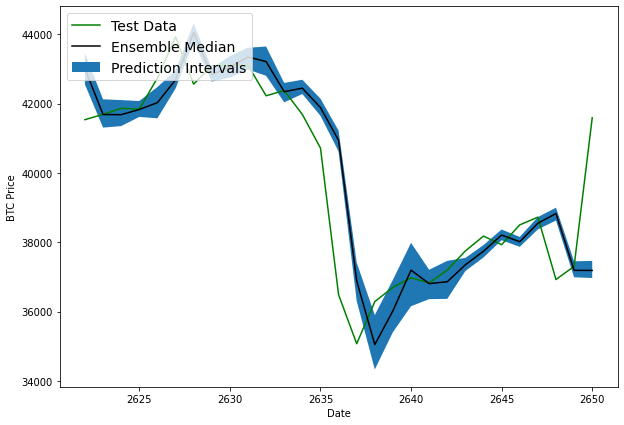

In [257]:
offset = 500

plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)